In [20]:
import pandas as pd
import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import numpy as np
import re
import seaborn as sns

from collections import defaultdict
import math
import random

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

读取数据

In [21]:
fifa15_df = pd.read_csv('cleaned_data/players_15.csv',index_col='Unnamed: 0')
fifa16_df = pd.read_csv('cleaned_data/players_16.csv',index_col='Unnamed: 0')
fifa17_df = pd.read_csv('cleaned_data/players_17.csv',index_col='Unnamed: 0')
fifa18_df = pd.read_csv('cleaned_data/players_18.csv',index_col='Unnamed: 0')
fifa19_df = pd.read_csv('cleaned_data/players_19.csv',index_col='Unnamed: 0')
fifa20_df = pd.read_csv('cleaned_data/players_20.csv',index_col='Unnamed: 0')
league_df = pd.read_csv('cleaned_data/teams_and_leagues.csv',index_col='Unnamed: 0')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15796\750790652.py:3: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa17_df = pd.read_csv('cleaned_data/players_17.csv',index_col='Unnamed: 0')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15796\750790652.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa18_df = pd.read_csv('cleaned_data/players_18.csv',index_col='Unnamed: 0')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15796\750790652.py:5: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa19_df = pd.read_csv('cleaned_data/players_19.csv',index_col='Unnamed: 0')


In [22]:
df_list=[fifa16_df,fifa17_df,fifa18_df,fifa19_df,fifa20_df]

In [39]:
fifa16_df.head(),league_df.head()

(   sofifa_id                                         player_url  \
 0     158023  https://sofifa.com/player/158023/lionel-messi/...   
 1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
 2       9014  https://sofifa.com/player/9014/arjen-robben/16...   
 3     167495  https://sofifa.com/player/167495/manuel-neuer/...   
 4     176580  https://sofifa.com/player/176580/luis-suarez/1...   
 
           short_name                            long_name  age         dob  \
 0           L. Messi       Lionel Andrés Messi Cuccittini   28  1987-06-24   
 1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   30  1985-02-05   
 2          A. Robben                         Arjen Robben   31  1984-01-23   
 3           M. Neuer                         Manuel Neuer   29  1986-03-27   
 4          L. Suárez             Luis Alberto Suárez Díaz   28  1987-01-24   
 
    height_cm  weight_kg  nationality               club  ...  \
 0        170         72    Argentina       FC Ba

确定测试的col 和训练的col

In [40]:
test_cols = ["English Premier League ","Spain Primera Division ", "German 1. Bundesliga ","French Ligue 1 ","Italian Serie A"]
train_teams=league_df[~league_df.league_name.isin(test_cols)].team
test_teams=league_df[league_df.league_name.isin(test_cols)].team

选择训练的feature

In [42]:
target_cols = ["overall","potential","value_eur","wage_eur","pace","shooting","dribbling",
               "defending","physic", "gk_diving","gk_handling","gk_kicking",
               "gk_reflexes", "gk_speed","gk_positioning"]
#target_cols = ["overall","potential","value_eur","pace","shooting","dribbling",
#                "defending","physic", "gk_diving","gk_handling","gk_kicking",
#                "gk_reflexes", "gk_speed","gk_positioning","attacking_crossing",
#               "attacking_finishing","attacking_heading_accuracy","attacking_short_passing",
#               "attacking_volleys","skill_dribbling","skill_curve","skill_fk_accuracy",
#                "skill_long_passing","skill_ball_control","movement_acceleration",
#               "movement_sprint_speed","movement_agility","movement_reactions","movement_balance",
#               "power_shot_power","power_jumping","power_stamina", "power_strength","power_long_shots"]

把 每年的训练集和测试集找出来

In [44]:
fifa15_test = fifa15_df[fifa15_df["club"].isin(test_teams)][target_cols]
fifa15_train = fifa15_df[~fifa15_df["club"].isin(test_teams)][target_cols]

fifa16_test = fifa16_df[fifa16_df["club"].isin(test_teams)][target_cols]
fifa16_train = fifa16_df[~fifa16_df["club"].isin(test_teams)][target_cols]

fifa17_test = fifa17_df[fifa17_df["club"].isin(test_teams)][target_cols]
fifa17_train = fifa17_df[~fifa17_df["club"].isin(test_teams)][target_cols]

fifa18_test = fifa18_df[fifa18_df["club"].isin(test_teams)][target_cols]
fifa18_train = fifa18_df[~fifa18_df["club"].isin(test_teams)][target_cols]

fifa19_test = fifa19_df[fifa19_df["club"].isin(test_teams)][target_cols]
fifa19_train = fifa19_df[~fifa19_df["club"].isin(test_teams)][target_cols]

fifa20_test = fifa20_df[fifa20_df["club"].isin(test_teams)][target_cols]
fifa20_train = fifa20_df[~fifa20_df["club"].isin(test_teams)][target_cols]


记录

其中一个思路就是：把四年的每一队的能力值进行平均，就OK了
假设四年没有队伍退出

In [48]:
def average_power(df_list):
    team_power_agg=[]
    for ele in df_list:
        temp=ele.loc[ele.club.isin(test_teams)].groupby('club').agg({'overall':'mean'}).overall.to_dict()
        for key,values in temp.items():
            temp[key]=round(values,2)
        team_power_agg.append(temp)
    return team_power_agg
def length_check(a):
    for ele in a :
        print(f'this  is the length : {len(ele)}')
team_power_agg=average_power(df_list)


In [50]:
length_check(team_power_agg)

this  is the length : 76
this  is the length : 77
this  is the length : 77
this  is the length : 78
this  is the length : 78


In [54]:
common_clubs=set(fifa16_df[fifa16_df.club.isin(test_teams)].club)&set(fifa17_df[fifa17_df.club.isin(test_teams)].club)&set(fifa18_df[fifa18_df.club.isin(test_teams)].club)&set(fifa19_df[fifa19_df.club.isin(test_teams)].club)&set(fifa20_df[fifa20_df.club.isin(test_teams)].club)
common_clubs

{'1. FC Köln',
 '1. FC Union Berlin',
 '1. FSV Mainz 05',
 'AS Monaco',
 'AS Saint-Étienne',
 'Angers SCO',
 'Arsenal',
 'Aston Villa',
 'Athletic Club de Bilbao',
 'Atlético Madrid',
 'Bayer 04 Leverkusen',
 'Borussia Dortmund',
 'Borussia Mönchengladbach',
 'Bournemouth',
 'Brighton & Hove Albion',
 'Burnley',
 'CA Osasuna',
 'CD Leganés',
 'Chelsea',
 'Crystal Palace',
 'Deportivo Alavés',
 'Dijon FCO',
 'Eintracht Frankfurt',
 'Everton',
 'FC Augsburg',
 'FC Barcelona',
 'FC Bayern München',
 'FC Girondins de Bordeaux',
 'FC Metz',
 'FC Nantes',
 'FC Schalke 04',
 'Fortuna Düsseldorf',
 'Getafe CF',
 'Granada CF',
 'Hertha BSC',
 'LOSC Lille',
 'Leicester City',
 'Levante UD',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Montpellier HSC',
 'Newcastle United',
 'Norwich City',
 'Nîmes Olympique',
 'OGC Nice',
 'Olympique Lyonnais',
 'Olympique de Marseille',
 'Paris Saint-Germain',
 'RB Leipzig',
 'RC Celta',
 'RCD Espanyol',
 'Real Betis',
 'Real Madrid',
 'Real Socied

把每一个队伍的16-20的能力值存储到一起，然后用一个dict 存储一下


In [55]:
clubs_power_five_year={}
for i in common_clubs:
    one_club_power_five_year=[]
    for j in team_power_agg:
        one_club_power_five_year.append(j[i])
    clubs_power_five_year[i]=one_club_power_five_year


In [56]:
clubs_power_five_year

{'Real Valladolid CF': [69.52, 68.5, 68.23, 69.35, 71.94],
 'SV Werder Bremen': [67.81, 71.52, 73.15, 71.94, 71.69],
 'Southampton': [72.06, 71.94, 71.88, 71.42, 72.24],
 'AS Saint-Étienne': [70.5, 71.45, 70.5, 71.0, 70.59],
 'Manchester United': [76.26, 77.91, 77.67, 77.45, 76.85],
 'Montpellier HSC': [69.33, 69.5, 69.86, 70.5, 70.85],
 'Sheffield United': [64.52, 63.5, 64.4, 66.27, 68.88],
 'Liverpool': [76.11, 74.73, 75.91, 76.0, 75.85],
 'Levante UD': [70.93, 70.39, 70.75, 72.27, 72.88],
 'Crystal Palace': [72.83, 71.27, 70.58, 71.12, 70.79],
 'Athletic Club de Bilbao': [76.12, 75.1, 75.75, 74.03, 73.73],
 'FC Nantes': [69.04, 68.71, 69.94, 70.42, 69.52],
 'Fortuna Düsseldorf': [67.62, 65.61, 66.5, 68.69, 69.76],
 'Atlético Madrid': [76.92, 77.45, 75.88, 74.73, 76.18],
 'Bournemouth': [69.9, 69.06, 70.15, 69.82, 72.3],
 'AS Monaco': [72.47, 71.27, 73.36, 73.12, 73.27],
 'Olympique de Marseille': [72.46, 69.23, 74.92, 73.79, 72.48],
 'Dijon FCO': [63.46, 69.04, 69.39, 70.12, 67.08],

计算增长率

In [57]:
clubs_increasing_rate={}
for key, values in clubs_power_five_year.items():
    increase_rate=pd.Series(values).pct_change()[1:].to_list()
    clubs_increasing_rate[key]=increase_rate

In [58]:
clubs_increasing_rate

{'Real Valladolid CF': [-0.014672036823935475,
  -0.003941605839416051,
  0.01641506668620818,
  0.03734679163662591],
 'SV Werder Bremen': [0.05471169444034785,
  0.022790827740492237,
  -0.016541353383458746,
  -0.0034751181540172427],
 'Southampton': [-0.0016652789342215257,
  -0.0008340283569642226,
  -0.006399554813578123,
  0.011481377765331757],
 'AS Saint-Étienne': [0.013475177304964614,
  -0.013296011196641033,
  0.007092198581560183,
  -0.005774647887323847],
 'Manchester United': [0.021636506687647383,
  -0.003080477474008414,
  -0.002832496459379441,
  -0.007746933505487497],
 'Montpellier HSC': [0.0024520409635078178,
  0.005179856115107961,
  0.009161179501860905,
  0.004964539007092039],
 'Sheffield United': [-0.01580905145691247,
  0.014173228346456845,
  0.029037267080745277,
  0.03938433680398368],
 'Liverpool': [-0.01813165155695695,
  0.0157901779740397,
  0.0011856145435384935,
  -0.0019736842105263497],
 'Levante UD': [-0.007613139715212269,
  0.005114362835630048

In [60]:
pct_change_17=[]
pct_change_17_index=[]
pct_change_18=[]
pct_change_18_index=[]
pct_change_19=[]
pct_change_19_index=[]
pct_change_20=[]
pct_change_20_index=[]

for key,values in clubs_increasing_rate.items():
    for i in range(4):
        if i==0:
            pct_change_17.append(values[0])
            pct_change_17_index.append(key)

        if i==1:
            pct_change_18.append(values[1])
            pct_change_18_index.append(key)
        if i==2:
            pct_change_19.append(values[2])
            pct_change_19_index.append(key)
        if i==3:
            pct_change_20.append(values[3])
            pct_change_20_index.append(key)
print(f'this is the 17 max change:{max(pct_change_17)}, and club is: { pct_change_17_index[np.argmax(pct_change_17)]}')
print(f'this is the 18 max change:{max(pct_change_18)},and club is :{ pct_change_18_index[np.argmax(pct_change_18)]}' )
print(f'this is the 19 max change:{max(pct_change_19)},and club is :{ pct_change_19_index[np.argmax(pct_change_19)]}')
print(f'this is the 20 max change:{max(pct_change_20)},and club is :{ pct_change_20_index[np.argmax(pct_change_20)]}')

this is the 17 max change:0.09795544705523329, and club is: CD Leganés
this is the 18 max change:0.08218980210891225,and club is :Olympique de Marseille
this is the 19 max change:0.04852418482460208,and club is :Nîmes Olympique
this is the 20 max change:0.05705521472392627,and club is :Stade Brestois 29


这里没有办法做出他们那样的合并图，先跳过吧

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15796\3191006560.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')


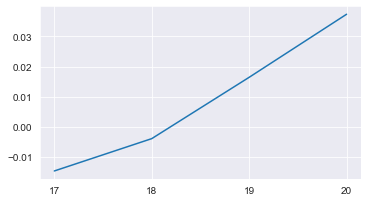

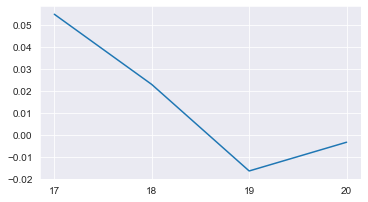

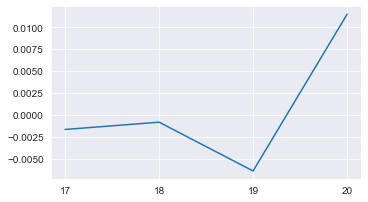

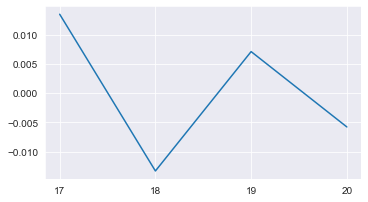

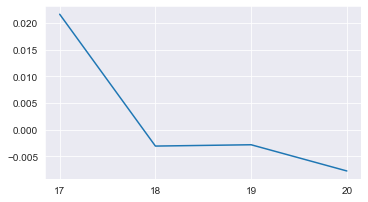

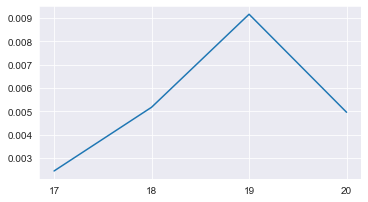

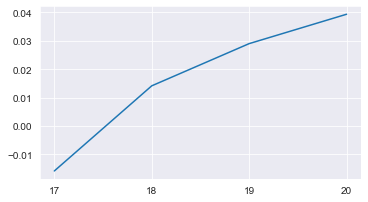

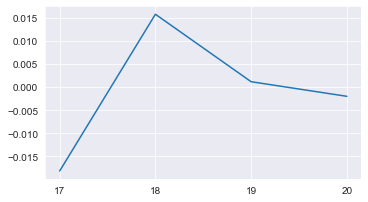

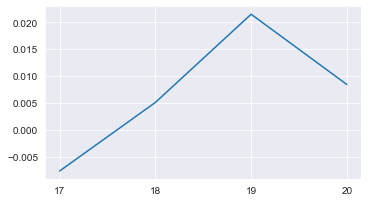

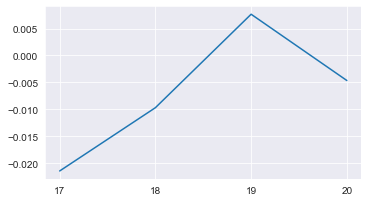

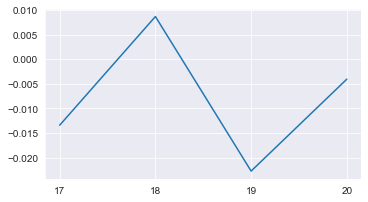

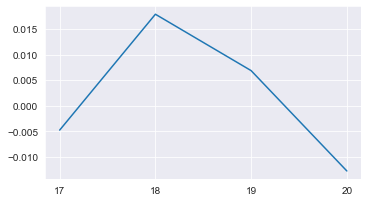

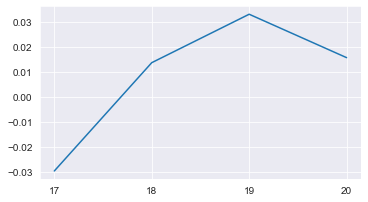

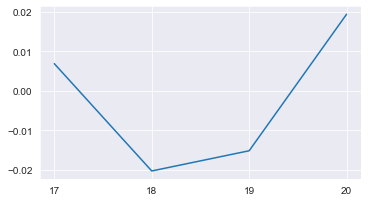

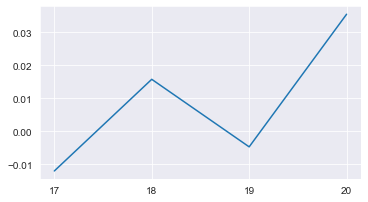

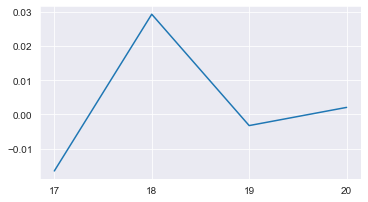

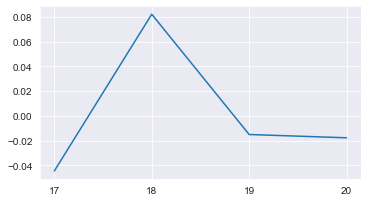

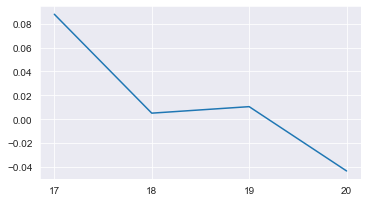

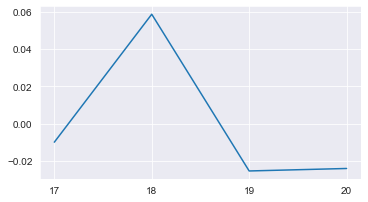

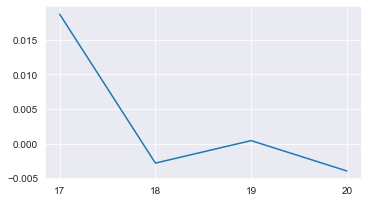

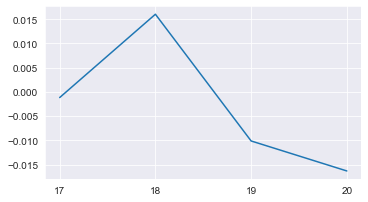

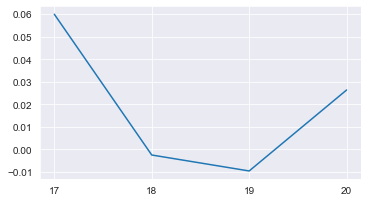

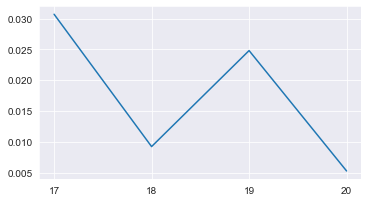

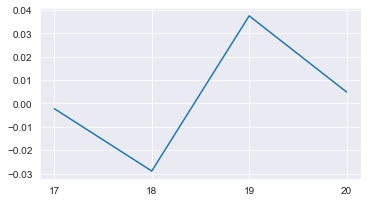

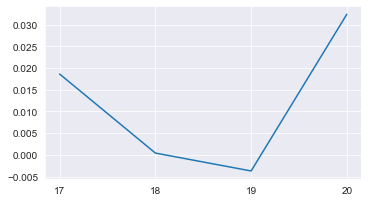

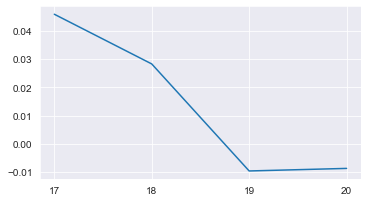

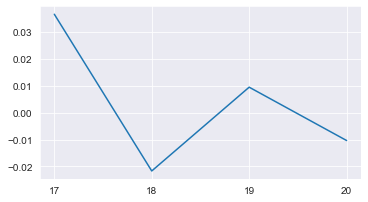

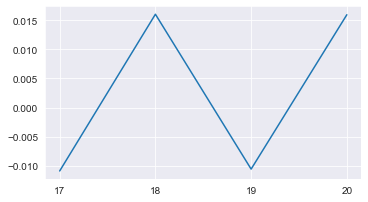

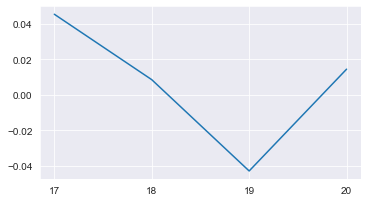

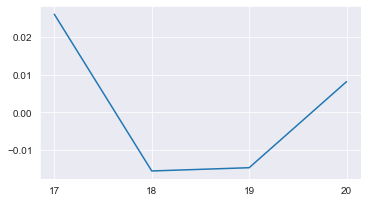

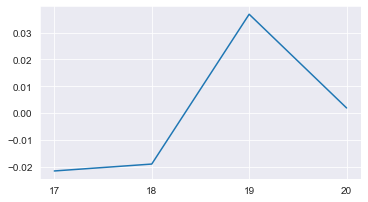

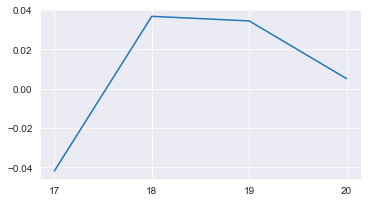

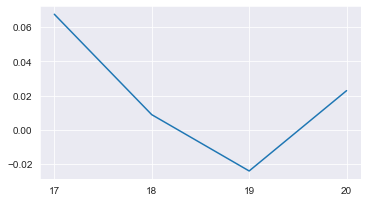

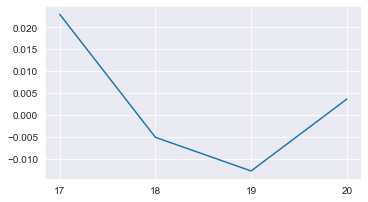

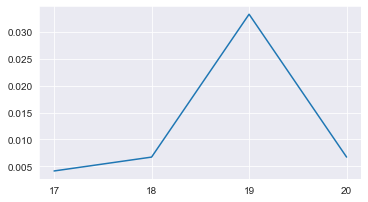

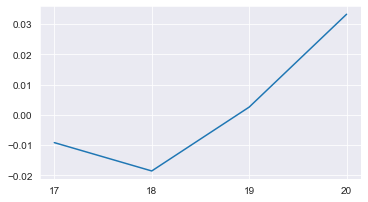

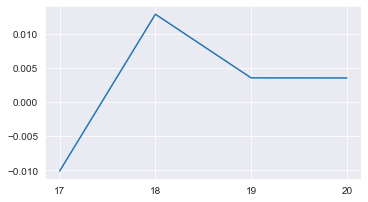

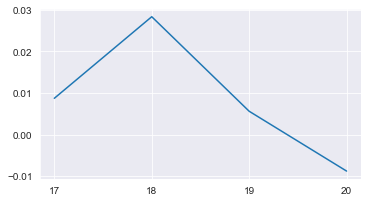

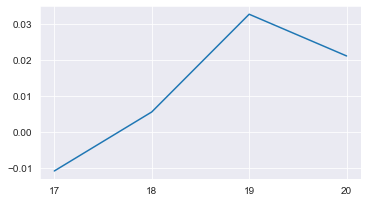

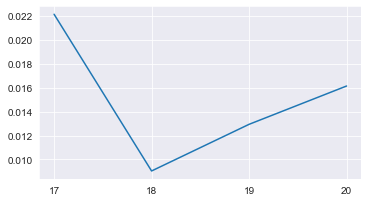

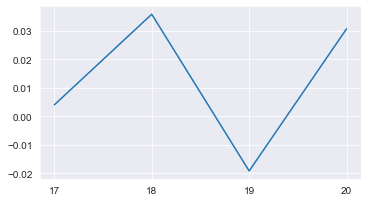

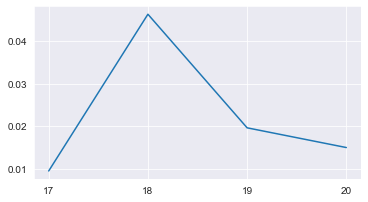

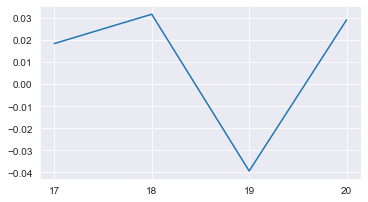

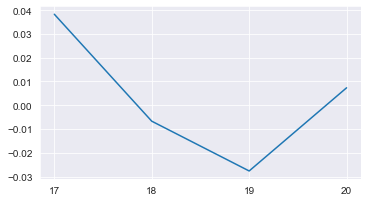

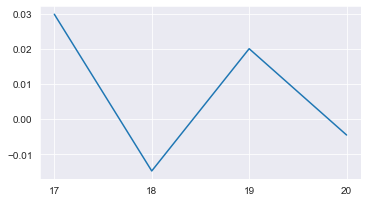

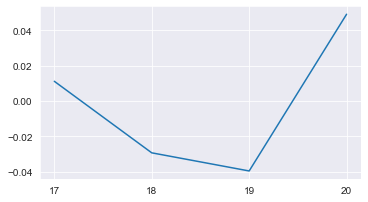

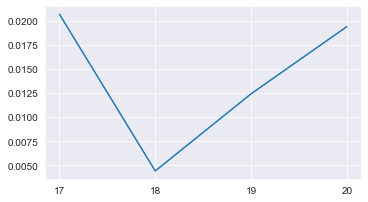

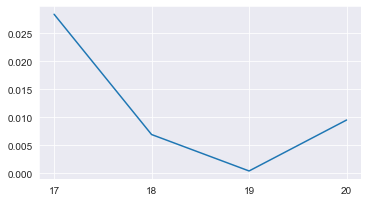

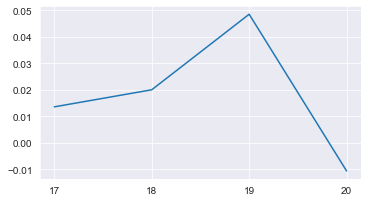

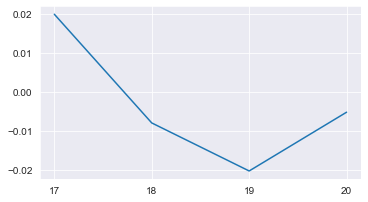

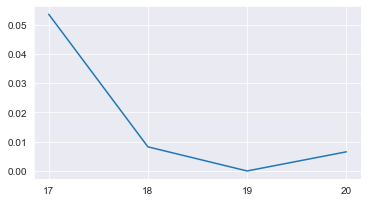

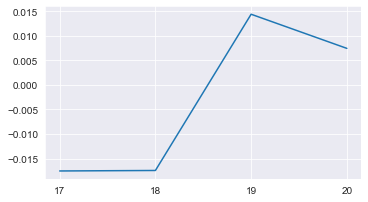

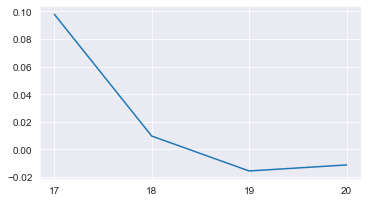

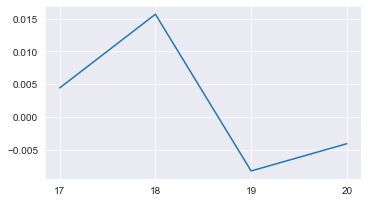

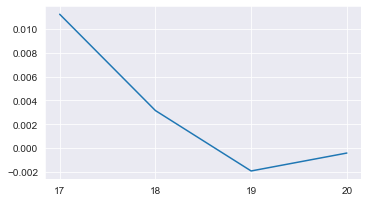

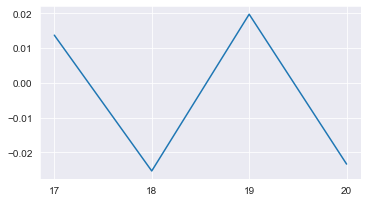

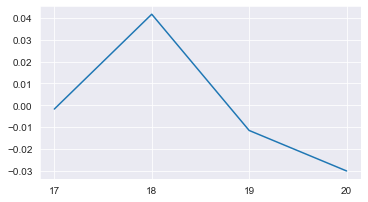

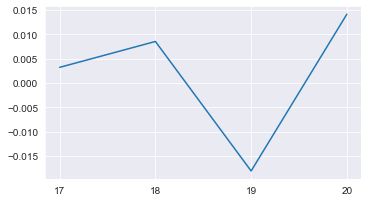

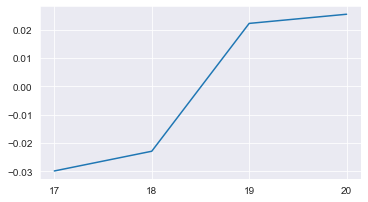

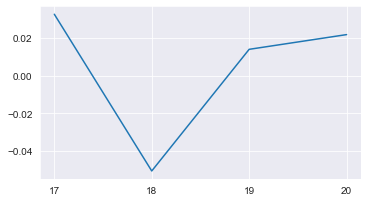

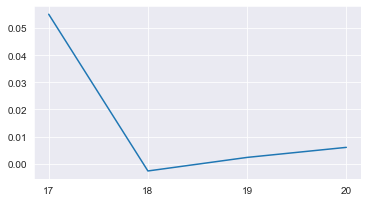

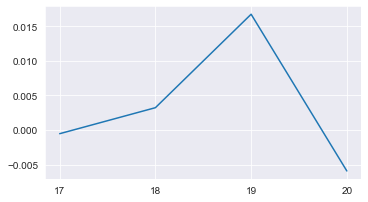

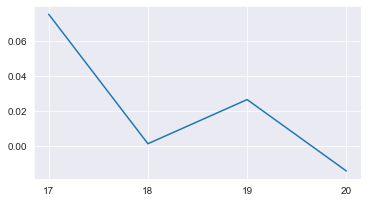

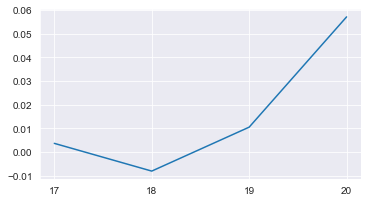

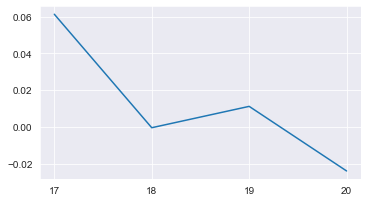

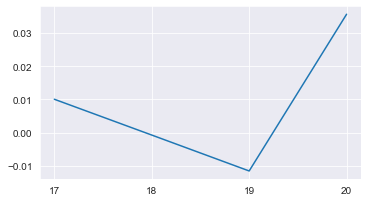

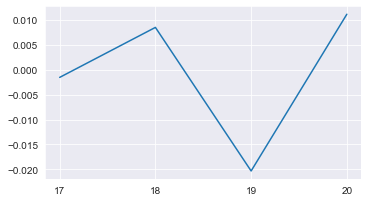

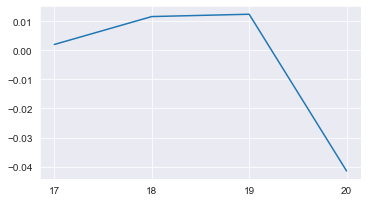

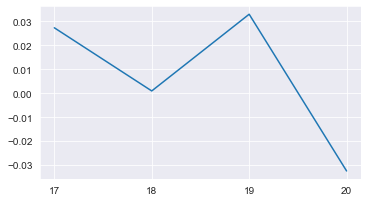

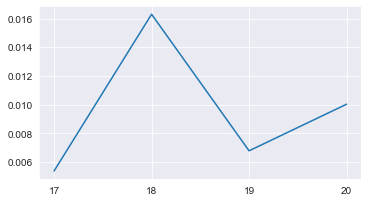

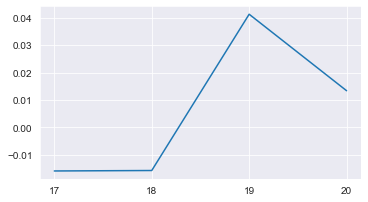

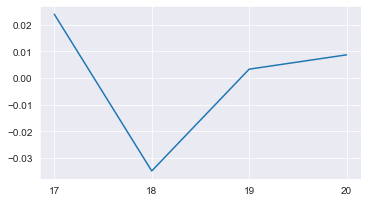

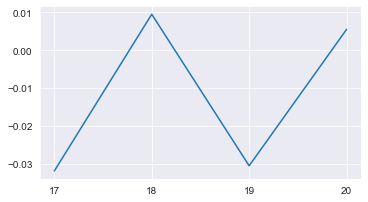

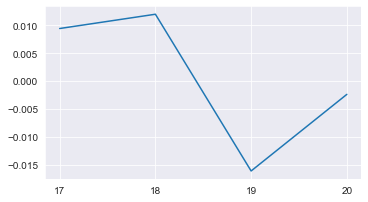

In [61]:

for key,values in clubs_increasing_rate.items():
    fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
    xticks=np.arange(17,21,1)
    ax.set_xticks(xticks, ['17', '18', '19', '20'])
    ax.plot(xticks,values)


接下来要开始建模咯